In [2]:
using LinearAlgebra
using Statistics: mean
using Flux
using Zygote
using GalacticOptim
using Optim
using Quadrature
using Plots

In [3]:
function D(f)
    return (x, θ) -> Zygote.pullback(y -> f(y, θ), x)[2](ones(1, size(x, 2)))[1]
end

const DIM = 2
const BATCH_SIZE = 25

function build_model()
    model = Chain(Dense(DIM, 10, tanh), Dense(10, 1))
    θ, re = Flux.destructure(model)
    ϕ(x, θ) = re(θ)(x)
    (model, ϕ, θ, re)
end

function get_domain()
    rand(Float32, DIM, BATCH_SIZE)
    #zip(domain[1, :], domain[2, :]) |> collect |> scatter
end

get_domain (generic function with 1 method)

In [4]:
"""
f is f(x, θ)
"""
function get_loss(f)
    bsize = BATCH_SIZE |> sqrt |> ceil |> Int # boundary data batch size
    points = range(0.0f0, 1.0f0, length = bsize)'
    bd_1 = [zeros(1, bsize); points]
    bd_2 = [ones(1, bsize); points]
    bd_3 = [points; zeros(1, bsize)]
    bd_4 = [points; ones(1, bsize)]
    f_1 = zeros(1, bsize)
    f_2 = zeros(1, bsize)
    f_3 = zeros(1, bsize)
    f_4 = @. sin(pi * points)

    pde_domain = get_domain()
    bv(i, n) = [j == i for j = 1:n]
    split(phi, n) = [(x, t) -> bv(i, n)' * phi(x, t) for i = 1:n]
    split(phi) = split(phi, DIM)
    fx, fy = split(D(f))
    fxx, _ = split(D(fx))
    _, fyy = split(D(fy))
    loss(θ, p) = begin
        eq_res = fxx(pde_domain, θ) + fyy(pde_domain, θ)
        eq_residual = mean(abs2, eq_res)
        bd_residual_1 = mean(abs2, f(bd_1, θ) - f_1)
        bd_residual_2 = mean(abs2, f(bd_2, θ) - f_2)
        bd_residual_3 = mean(abs2, f(bd_3, θ) - f_3)
        bd_residual_4 = mean(abs2, f(bd_4, θ) - f_4)
        +(
            bd_residual_1,
            bd_residual_2,
            bd_residual_3,
            bd_residual_4,
            eq_residual,
        )
    end
    loss_hard(θ, p) = begin
        r = loss(θ, p)
        r + log1p(1f5 * r) * 1f-3 # This is magic (number)
    end
end

get_loss

In [5]:
function train()
    _, ϕ, θ, re = build_model()

    opt_f = OptimizationFunction(get_loss(ϕ), GalacticOptim.AutoForwardDiff())
    prob = OptimizationProblem(opt_f, θ)
    sol = solve(prob, Optim.BFGS())

    x_test = range(0, 1, length = 20)
    y_test = range(0, 1, length = 20)
    exact(x) = begin
        sin(pi * x[1]) * sinh(pi * x[2]) / sinh(pi)
    end
    f(x, p) = ϕ([x[1]; x[2]], sol.minimizer) .- exact(x) .|> abs2
    prob = QuadratureProblem(f, zeros(2), ones(2))
    solution = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    p = contour(x_test, y_test, (x, y) -> ϕ([x; y], sol.minimizer)[1])
    annotate!(p, 0.5, 0.5, solution.u)
    (ϕ, sol, p)
end

train (generic function with 1 method)

In [6]:
@fastmath @inbounds f, s, p = train()

(var"#ϕ#5"{Flux.var"#34#36"{Chain{Tuple{Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}(Flux.var"#34#36"{Chain{Tuple{Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Dense(2, 10, tanh), Dense(10, 1)))),  * Status: success

 * Candidate solution
    Final objective value:     5.105537e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.49e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.77e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.34e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   49  (vs limit Inf)
    Iterations:    690
    f(x) calls:    2064
    ∇f(x) calls:   2064
, Plot{Plots.GRBackend() n=1})

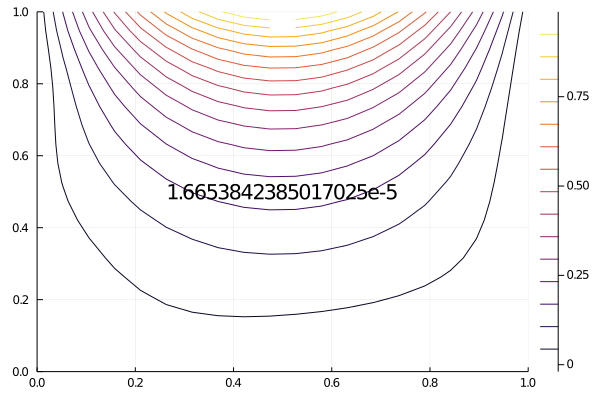

In [8]:
p